# Convolutional Autoencoder

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


### Device Selection

In [2]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [3]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

### Data loading

In [4]:
batch_size = 128

if not os.path.exists('./CAE'):
    os.makedirs('./CAE')

NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image(denorm(fixed_input), './CAE/input_sample.png')

0it [00:00, ?it/s]

170500096it [00:06, 26237038.44it/s]                               


Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [0]:
num_epochs = 20
learning_rate = 1e-3

### Define model

In [0]:
hidden_size = 256

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
    
        # encoder layers
        self.conv1 = nn.Conv2d(3, 60, 3, stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv2 = nn.Conv2d(60, 80, 3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       
        self.conv3 = nn.Conv2d(80, 120, 3, stride=1)
        self.batch3 = nn.BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
               
        self.conv4 = nn.Conv2d(120, 160, 2, stride=1)  
          
        self.lin_enc = nn.Linear(640, hidden_size)
        
        # decoder layers
        self.lin_dec = nn.Linear(hidden_size, 640)
        
        self.deconv1 = nn.ConvTranspose2d(160, 120, 4, stride=2)
        self.deconv2 = nn.ConvTranspose2d(120, 80, 4, stride=2)
        self.deconv3 = nn.ConvTranspose2d(80, 60, 4, stride=2)
        self.deconv4 = nn.ConvTranspose2d(60, 3, 3, stride=1)

        # max pooling 
        self.maxp = nn.MaxPool2d(2, stride=2, dilation=1)
        
        # relu / tanh
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()    

    def encode(self, x):
        
        x = self.relu(self.conv1(x))
        #x = self.batch1(x)
        x = self.maxp(x)
        x = self.relu(self.conv2(x))
        #x = self.batch2(x)
        x = self.maxp(x)
        x = self.relu(self.conv3(x))
        #x = self.batch3(x)
        x = self.maxp(x)
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.lin_enc(x)
        return x 
    
    def decode(self, z):

        z = self.lin_dec(z)
        z = z.view(z.size(0), 160, 2, 2)
        z = self.relu(self.deconv1(z))
        #z = self.batch3(z)
        z = self.relu(self.deconv2(z))
        #z = self.batch2(z)
        z = self.relu(self.deconv3(z))
        z = self.tanh(self.deconv4(z))
        return z     

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon

### Define Loss function

In [0]:
criterion = nn.MSELoss(reduction='mean')
def loss_function_CAE(recon_x, x):
    recon_loss = criterion(recon_x, x)
    return recon_loss

### Initialize Model and print number of parameters

In [8]:
model = CAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

Total number of parameters is: 1077019
CAE(
  (conv1): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(60, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(80, 120, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(120, 160, kernel_size=(2, 2), stride=(1, 1))
  (lin_enc): Linear(in_features=640, out_features=256, bias=True)
  (lin_dec): Linear(in_features=256, out_features=640, bias=True)
  (deconv1): ConvTranspose2d(160, 120, kernel_size=(4, 4), stride=(2, 2))
  (deconv2): ConvTranspose2d(120, 80, kernel_size=(4, 4), stride=(2, 2))
  (deconv3): ConvTranspose2d(80, 60, kernel_size=(4, 4), stride=(2, 2))
  (deconv4): ConvTranspose2d(60, 3, kernel_size=(3

### Choose and initialize optimizer

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train

In [10]:
train_losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(loader_train):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        # forward
        recon_batch = model(img)
        loss = loss_function_CAE(recon_batch, img)
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(loader_train)))
    recon = model(fixed_input.to(device))
    recon = denorm(recon.cpu())
    save_image(recon, './CAE/reconstructed_epoch_{}.png'.format(epoch))
    train_losses.append(train_loss/ len(loader_train))

# save the model and the loss values
np.save('./CAE/train_losses.npy', np.array(train_losses))
torch.save(model.state_dict(), './CAE/CAE_model.pth')

epoch [1/20], loss:0.0952
epoch [2/20], loss:0.0537
epoch [3/20], loss:0.0456
epoch [4/20], loss:0.0401
epoch [5/20], loss:0.0364
epoch [6/20], loss:0.0341
epoch [7/20], loss:0.0319
epoch [8/20], loss:0.0304
epoch [9/20], loss:0.0290
epoch [10/20], loss:0.0279
epoch [11/20], loss:0.0269
epoch [12/20], loss:0.0261
epoch [13/20], loss:0.0253
epoch [14/20], loss:0.0246
epoch [15/20], loss:0.0240
epoch [16/20], loss:0.0233
epoch [17/20], loss:0.0229
epoch [18/20], loss:0.0223
epoch [19/20], loss:0.0219
epoch [20/20], loss:0.0215


### Train loss curve

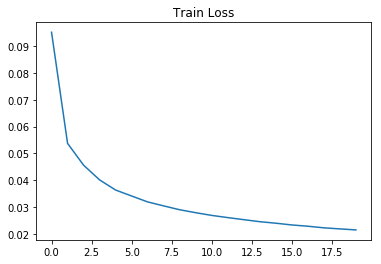

In [11]:
import matplotlib.pyplot as plt
train_losses = np.load('./CAE/train_losses.npy')
plt.plot(list(range(0,train_losses.shape[0])), train_losses)
plt.title('Train Loss')
plt.show()

### Test set reconstruction error

In [12]:
# load the model
model.load_state_dict(torch.load('./CAE/CAE_model.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(loader_test):
        img,_ = data
        img = img.to(device)
        recon_batch = model(img)
        test_loss += loss_function_CAE(recon_batch, img)
    # loss calculated over the whole test set
    test_loss /= len(loader_test.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

Test set loss: 0.0002


### Test set images and reconstructions

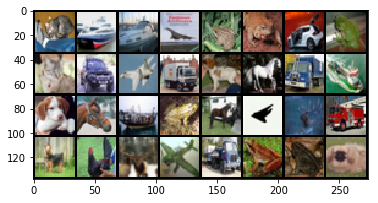

In [13]:
# load the model
model.load_state_dict(torch.load('./CAE/CAE_model.pth'))
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

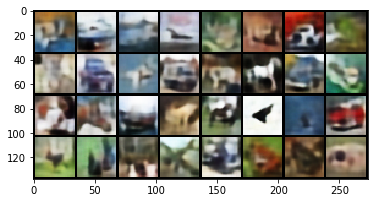

In [14]:
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    recon_batch = model(fixed_input.to(device)).cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)